# Feature Extraction and Modeling

# General Setup

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms

from torchvision.models import resnet50, ResNet50_Weights

from torch.utils.data import DataLoader
import os
import sklearn.model_selection as model_selection
import sklearn.linear_model as linear_model
import subprocess
from tqdm import tqdm

from sklearn.decomposition import PCA, KernelPCA

from sklearn.neural_network import MLPClassifier

from methods import (
    get_labels,
    ImageHeuristicFeatureExtractor,
    standardize_features,
    ImageDataset,
    merge_features_with_labels,
    not_oversampled_images,
    calculate_test_size,
    plot_confusion_matrix,
    plot_low_dim_components,
)

from data_augmentation import split_data_and_oversample

from sklearn.preprocessing import StandardScaler
from sklearn import svm

from sklearn.manifold import TSNE
import shap

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
import matplotlib.pylab as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 10})

In [176]:
# load repo and
repo_dir = (
    subprocess.Popen(["git", "rev-parse", "--show-toplevel"], stdout=subprocess.PIPE)
    .communicate()[0]
    .rstrip()
    .decode("utf-8")
)

# Set the folder containing the raw images
# original_folder_path = os.path.join(repo_dir, "dataverse_files/HAM10000_images_part_1")
original_folder_path = os.path.join(
    repo_dir, "dataverse_files/HAM10000_images_part_1_2_3"
)
# original_folder_path = os.path.join(repo_dir, "dataverse_files/JS_Selection")

# Create Folders
features_folder_path = os.path.join(repo_dir, "features_extracted")
processed_folder_path = os.path.join(repo_dir, "preprocessed_images")
figures_folder_path = os.path.join(repo_dir, "figures")
os.makedirs(processed_folder_path, exist_ok=True)
os.makedirs(features_folder_path, exist_ok=True)
os.makedirs(figures_folder_path, exist_ok=True)

# get pandas dataframe
label = get_labels(repo_dir)

# Load old features (or write new features using this name)
cnn_features_path = os.path.join(features_folder_path, "features.json")

TRAIN_SIZE = 0.8
OVERSAMPLE = True  #  if set to false will not oversample the minority class

if "oversampled" in cnn_features_path and OVERSAMPLE:
    data_folder_path = processed_folder_path
else:
    data_folder_path = original_folder_path

# Oversampling

In [ ]:
if OVERSAMPLE:
    if not os.listdir(data_folder_path):
        try:
            split_data_and_oversample(
                original_folder_path,
                processed_folder_path,
                label,
                TRAIN_SIZE,
                oversample=OVERSAMPLE,
                move_picture_up_levels=2,
            )
        except OSError as e:
            print(e)
            assert False, "delete the Folder 'preprocessed_images' and try again"
    else:
        print(f"Used pre-processed features at {data_folder_path}")

# Feature Extraction

## (A) Feature Exctraction using ResNet50 (CNN)

In [ ]:
# Using the RestNet 50 model to extract features using pretrained weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize(232),
        transforms.CenterCrop(450),  # adapted to use larger region
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
dataset = ImageDataset(directory=data_folder_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
# Determine the best available device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

In [ ]:
if not os.path.exists(cnn_features_path):
    model = model.to(device)  # Move your model to the appropriate device
    model.eval()  # Set the model to evaluation mode

    features_map2 = {}
    with torch.no_grad():
        for batch_idx, (key, images) in enumerate(tqdm(data_loader)):
            images = images.to(device)  # Move images to the appropriate device

            batch_features = model(images)
            batch_features = batch_features.view(
                batch_features.size(0), -1
            )  # Flatten features

            batch_features = (
                batch_features.cpu().numpy()
            )  # Move features to CPU for numpy conversion

            for i, feature in enumerate(batch_features):
                image_id = (
                    batch_idx * data_loader.batch_size + i
                )  # Compute global image ID/index
                features_map2[key[i]] = feature

    # Saving the raw features
    features_df = pd.DataFrame(features_map2)
    features_df.to_json(cnn_features_path)
else:
    print(f"Previously computed features used: {cnn_features_path}")

### Load CNN Features (also previously generated)

In [111]:
# load features + combine the features with labels dataframe
cnn_features = merge_features_with_labels(
    features_path=cnn_features_path,
    labels_df=label,
    export=True,
)

## (B) Heuristic Feature Extraction
Attention! The order of the features using the CNN and this Class is not necessarily the same!

In [8]:
extractor = ImageHeuristicFeatureExtractor(
    data_folder_path, label.set_index("image_id")
)

feature_label_data = extractor.get_feature_and_label_arrays()
df_heuristic = (
    extractor.return_one_df()
)  # effectively dummy df with the filenames and image ids

x_rgb, y_rgb = feature_label_data["rgb"]
x_hsv, y_hsv = feature_label_data["hsv"]
x_glcm, y_glcm = feature_label_data["glcm"]
# x_gabor, y_gabor = feature_label_data['gabor']

100%|██████████| 17053/17053 [15:02<00:00, 18.89it/s]


In [9]:
np.save(os.path.join(features_folder_path, "x_rgb"), x_rgb)
np.save(os.path.join(features_folder_path, "y_rgb"), y_rgb)

np.save(os.path.join(features_folder_path, "x_hsv"), x_hsv)
np.save(os.path.join(features_folder_path, "y_hsv"), y_hsv)

np.save(os.path.join(features_folder_path, "x_glcm"), x_glcm)
np.save(os.path.join(features_folder_path, "y_glcm"), y_glcm)

np.save(os.path.join(features_folder_path, "x_heuristic"), x_heuristic)
np.save(os.path.join(features_folder_path, "y_heuristic"), y_heuristic)
np.save(
    os.path.join(features_folder_path, "names_heuristic_features"),
    names_heuristic_features,
)

df_heuristic.to_csv(os.path.join(features_folder_path, "df_heuristic"), index=True)

In [166]:
x_rgb = np.load(os.path.join(features_folder_path, "x_rgb.npy"))
y_rgb = np.load(os.path.join(features_folder_path, "y_rgb.npy"))
x_hsv = np.load(os.path.join(features_folder_path, "x_hsv.npy"))
y_hsv = np.load(os.path.join(features_folder_path, "y_hsv.npy"))
x_glcm = np.load(os.path.join(features_folder_path, "x_glcm.npy"))
y_glcm = np.load(os.path.join(features_folder_path, "y_glcm.npy"))

x_heuristic = np.load(os.path.join(features_folder_path, "x_heuristic.npy"))
y_heuristic = np.load(os.path.join(features_folder_path, "y_heuristic.npy"))
names_heuristic_features = np.load(
    os.path.join(features_folder_path, "names_heuristic_features.npy")
)
df_heuristic = pd.read_csv(
    os.path.join(features_folder_path, "df_heuristic"), index_col=0
)

In [167]:
x_rgb_standardized = standardize_features(x_rgb, use_pca=True, n_components=0.9)
x_hsv_stanardized = standardize_features(x_hsv, use_pca=True, n_components=0.9)

x_heuristic = np.concatenate((x_rgb_standardized, x_hsv_stanardized, x_glcm), axis=1)
y_heuristic = y_hsv
np.shape(x_heuristic)

(11526, 95)

In [165]:
names_heuristic_features = []

for i in range(len(x_rgb_standardized[0])):
    names_heuristic_features.append(f"rgb{i}")

for i in range(len(x_hsv_stanardized[0])):
    names_heuristic_features.append(f"hsv{i}")

for i in range(len(x_glcm[0])):
    names_heuristic_features.append(f"glcm{i}")

len(names_heuristic_features)

95

# Modeling

## Generate the Train and Test Split

In [168]:
# Define which x and y to use

# CNN:
"""
x = cnn_features.iloc[:, :1000].to_numpy()
y = cnn_features["cancer"].to_numpy()
df_ = cnn_features
"""
# Heuristic

x = x_heuristic
y = y_heuristic
df_ = df_heuristic
np.shape(x)

(11526, 95)

In [169]:
# only include those files in testing that have not been oversampled
include_in_testing = not_oversampled_images(df_)

TEST_SIZE = 0.20

# Calculate the adjusted test size
test_size_sklearn = calculate_test_size(df_, TEST_SIZE, include_in_testing)

x_train_, x_test, y_train_, y_test = model_selection.train_test_split(
    x[include_in_testing], y[include_in_testing], test_size=test_size_sklearn,
    random_state=42
)
x_train = np.concatenate((x_train_, x[np.invert(include_in_testing)]), axis=0)
y_train = np.concatenate((y_train_, y[np.invert(include_in_testing)]), axis=0)

In [170]:
print(
    f"{len(y_test)} Unique Images used Test Set: {len(y_test) / len(np.unique(df_.image_id)) * 100:.2f}%"
)
print(f"{len(y_train)} Non-Unique Images used Train Set")

2306 Unique Images used Test Set: 20.01%
9220 Non-Unique Images used Train Set


## Dimensionality Reduction
### PCA

In [141]:
# Initialize PCA,
pca = PCA(n_components=0.999)

# Fit and transform the data
pca.fit(np.concatenate((x_train, x_test), axis=0))
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

# Check the new shape of the data
print(x_train_pca.shape)

(9220, 789)


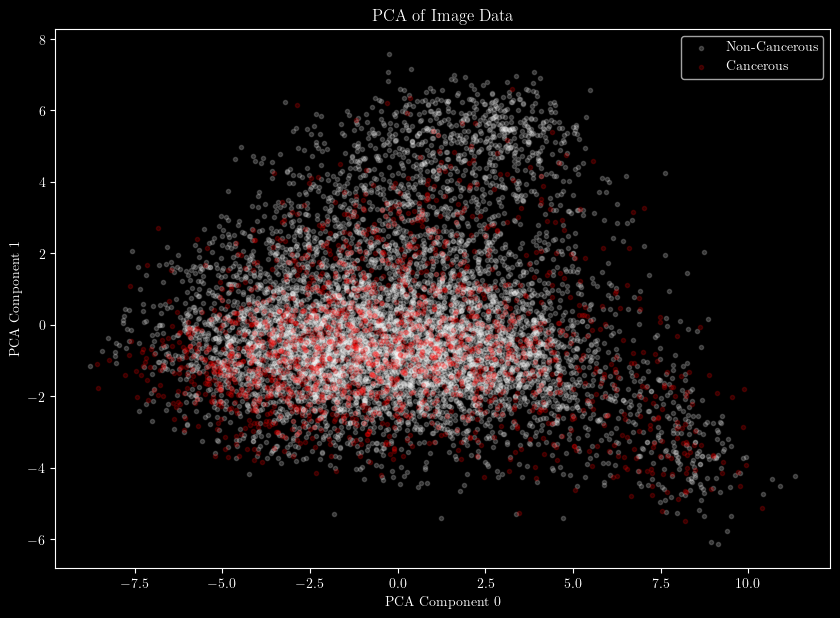

In [142]:
plot_low_dim_components(x_train_pca, y_train, component_1=0, component_2=1)

In [181]:
#plt.style.use('dark_background') # dark_background # default
plt.style.use('default')

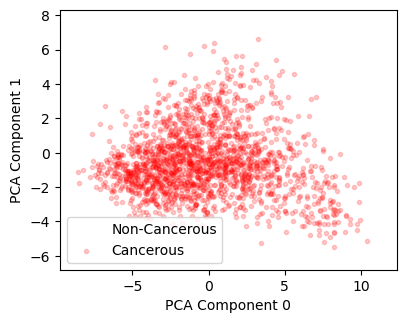

In [182]:
fig = plot_low_dim_components(x_train_pca, y_train, component_1=0, component_2=1, return_fig=True)
fig.set_size_inches(5/1.2,4/1.2)
plt.gca().set_title("")
fig.tight_layout()
fig.savefig(figures_folder_path + "/pca.pdf")
fig.savefig(figures_folder_path + "/pca.png", dpi=600, transparent=True)

### Kernel PCA (slow)

In [ ]:
# Initialize PCA,
kpca = KernelPCA(n_components=25, kernel="rbf")  # kernel: rbf, sigmoid

# Fit and transform the data
kpca.fit(np.concatenate((x_train, x_test), axis=0))
x_train_kpca = kpca.transform(x_train)
x_test_kpca = kpca.transform(x_test)

# Check the new shape of the data
print(x_train_kpca.shape)

In [ ]:
plot_low_dim_components(x_train_kpca, y_train, label="kPCA")

### t-SNE (Visualisation *only*)

In [ ]:
# Set the parameters for t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=2000, verbose=1)

# Perform t-SNE on the data
X_tsne = tsne.fit_transform(np.concatenate((x_train, x_test), axis=0))

In [ ]:
plot_low_dim_components(
    X_tsne, np.concatenate((y_train, y_test), axis=0), label="t-SNE"
)


In [ ]:
fig = plot_low_dim_components(
    X_tsne, np.concatenate((y_train, y_test), axis=0), label="t-SNE", return_fig=True
)
fig.set_size_inches(5/1.2,4/1.2)
plt.gca().set_title("")
fig.tight_layout()
fig.savefig(figures_folder_path + "/t_sne.pdf")

### Use Lower Dimensional Features?

In [136]:
x_train = x_train_pca  # x_train #x_train_kpca #x_train_pca
x_test = x_test_pca  # x_test #x_test_kpca#x_test_pca

## LogisticRegression

Accuracy: 0.6951431049436253
Precision: 0.3672431332655137
Recall: 0.8167420814479638
F1 Score: 0.5066666666666666


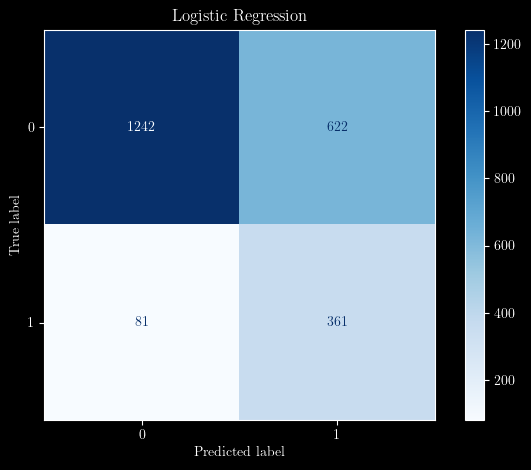

In [171]:
prediction_model = linear_model.LogisticRegression(
    solver="newton-cg", multi_class="auto", max_iter=10000, class_weight="balanced",
)

prediction_model.fit(x_train, y_train)

y_train_pred = prediction_model.predict(x_train)
y_pred = prediction_model.predict(x_test)

cf = plot_confusion_matrix(y_test, y_pred, return_fig=True)
fig = cf.figure_
plt.gca().set_title("Logistic Regression")
fig.tight_layout()
fig.savefig(figures_folder_path + "/log_regression.pdf")

## SVM

In [ ]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

# Create an SVM classifier
prediction_model = svm.SVC(
    kernel="poly",
    C=1.0,
    gamma=0.5,
    class_weight="balanced",
)

# Train the classifier
prediction_model.fit(x_train, y_train)

# Make predictions
y_pred = prediction_model.predict(x_test)

cf = plot_confusion_matrix(y_test, y_pred, return_fig=True)
fig = cf.figure_
plt.gca().set_title("SVM")
fig.tight_layout()
fig.savefig(figures_folder_path + "/svm.pdf")

## MLPClassifier

Accuracy: 0.8130962705984388
Precision: 0.1716101694915254
Recall: 0.6694214876033058
F1 Score: 0.27318718381112983


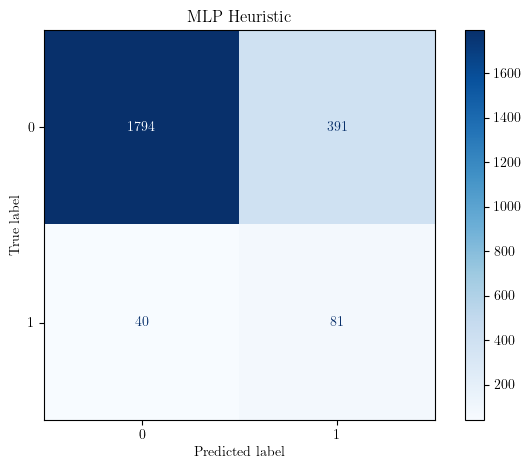

In [27]:
# solvers = ["lbfgs", "sgd", "adam"]
prediction_model = MLPClassifier(
    hidden_layer_sizes=[400] * 4,
    random_state=1,
    verbose=0,
    solver="adam",
    #learning_rate="adaptive",
)
prediction_model.fit(x_train, y_train)
y_pred = prediction_model.predict(x_test)

cf = plot_confusion_matrix(y_test, y_pred, return_fig=True)
fig = cf.figure_
plt.gca().set_title("MLP Heuristic")
fig.tight_layout()
fig.savefig(figures_folder_path + "/mlp_heuristic_PCA.pdf")

## AdaBoost Classifer  

Accuracy: 0.7879444926279271
Precision: 0.15019011406844107
Recall: 0.6528925619834711
F1 Score: 0.2442040185471407


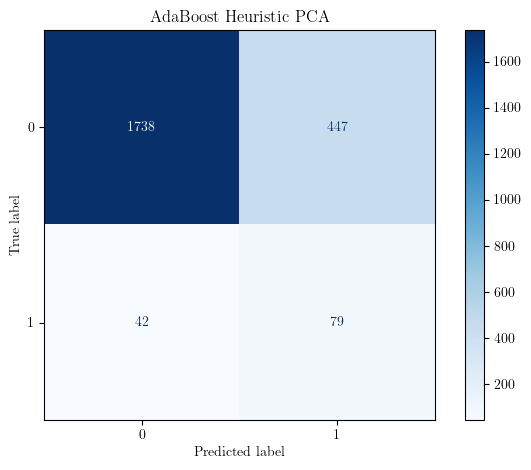

In [28]:
estimator = DecisionTreeClassifier(max_depth=3)
prediction_model = AdaBoostClassifier(
    estimator=estimator, n_estimators=500, algorithm="SAMME", random_state=0
)
prediction_model.fit(x_train, y_train)
y_pred = prediction_model.predict(x_test)

cf = plot_confusion_matrix(y_test, y_pred, return_fig=True)
fig = cf.figure_
plt.gca().set_title("AdaBoost Heuristic PCA")
fig.tight_layout()
fig.savefig(figures_folder_path + "/adaboost_heuristic_PCA.pdf")

## SHAP Values
We can see how much individual features are influencing the result

In [172]:
# Create the SHAP Explainer

# Without names
#explainer = shap.Explainer(prediction_model.predict, x_train, max_evals=2500, verbose=1)

# With names (only defined for heuristic model)
explainer = shap.Explainer(prediction_model.predict, x_train, max_evals=4000, verbose=1, feature_names=names_heuristic_features)

shap_values = explainer(x_test)

PermutationExplainer explainer: 2307it [02:55, 12.47it/s]                          


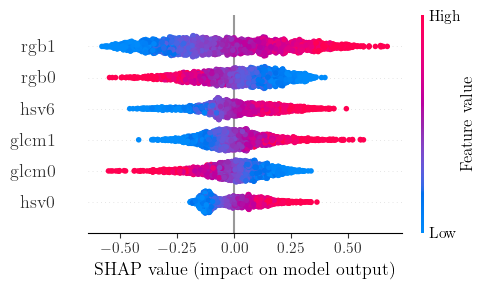

In [185]:
fig = plt.figure()
shap.summary_plot(shap_values, x_test, max_display=6, plot_size=[5,3])

# Save the current figure
save_path = os.path.join(figures_folder_path, "shap_values.pdf")
fig.savefig(save_path, dpi=300, bbox_inches="tight")
fig.savefig(os.path.join(figures_folder_path, "shap_values.png"), dpi=600, bbox_inches="tight", transparent=True)


In [186]:
histograms_rgb_cancer_avg = np.mean(x_rgb[y_rgb == True].reshape(len(x_rgb[y_rgb == True]), 3, -1), axis=0)
histograms_rgb_benign_avg = np.mean(x_rgb[y_rgb == False].reshape(len(x_rgb[y_rgb == False]), 3, -1), axis=0)

In [79]:
plt.style.use('default') # dark_background

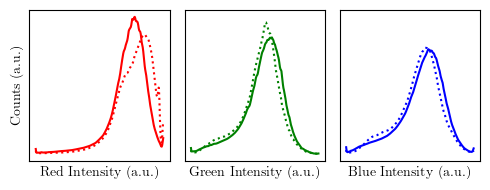

In [199]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 2), sharex=True, sharey=True) # 7, 3, )

ax1 = axes[0]
ax1.plot(histograms_rgb_cancer_avg[0], "r", label="cancer")
ax1.plot(histograms_rgb_benign_avg[0], ":r", label="benign")
ax1.set_xlabel("Red Intensity (a.u.)")
ax1.set_ylabel("Counts (a.u.)")
ax1.set_yticks([])
ax1.set_xticks([])
ax1.grid(True)
#ax1.legend(loc=2)

ax2 = axes[1]
ax2.plot(histograms_rgb_cancer_avg[1], "g", label="cancer")
ax2.plot(histograms_rgb_benign_avg[1], ":g", label="benign")
ax2.set_xlabel("Green Intensity (a.u.)")
#ax2.set_ylabel("Counts (a.u.)")
#ax2.legend(loc=2)

ax3 = axes[2]
ax3.plot(histograms_rgb_cancer_avg[2], "b", label="cancer")
ax3.plot(histograms_rgb_benign_avg[2], ":b", label="benign")
ax3.set_xlabel("Blue Intensity (a.u.)")
#ax3.set_ylabel("Counts (a.u.)")
#ax3.legend(loc=2)
plt.grid()

fig.tight_layout()
fig.savefig("figures/rgb_hist.pdf", dpi=300, transparent=True)
fig.savefig("figures/rgb_hist.png", dpi=300, transparent=True)

In [201]:
histograms_hsv_cancer_avg = np.mean(x_hsv[y_rgb == True].reshape(len(x_hsv[y_rgb == True]), 3, -1), axis=0)
histograms_hsv_benign_avg = np.mean(x_hsv[y_rgb == False].reshape(len(x_hsv[y_rgb == False]), 3, -1), axis=0)

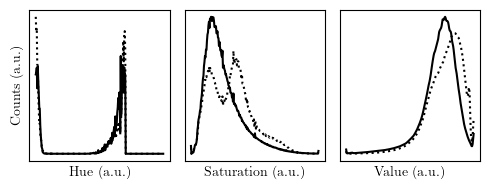

In [210]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 2), sharex=True, sharey=False) # 7, 3, )

ax1 = axes[0]
ax1.plot(histograms_hsv_cancer_avg[0], "k", label="cancer")
ax1.plot(histograms_hsv_benign_avg[0], ":k", label="benign")
ax1.set_xlabel("Hue (a.u.)")
ax1.set_ylabel("Counts (a.u.)")
ax1.set_yticks([])
ax1.set_xticks([])
#ax1.legend(loc=2)

ax2 = axes[1]
ax2.plot(histograms_hsv_cancer_avg[1], "k", label="cancer")
ax2.plot(histograms_hsv_benign_avg[1], ":k", label="benign")
ax2.set_xlabel("Saturation (a.u.)")
#ax2.set_ylabel("Counts (a.u.)")
#ax2.legend(loc=2)
ax2.set_yticks([])

ax3 = axes[2]
ax3.plot(histograms_hsv_cancer_avg[2], "k", label="cancer")
ax3.plot(histograms_hsv_benign_avg[2], ":k", label="benign")
ax3.set_xlabel("Value (a.u.)")
#ax3.set_ylabel("Counts (a.u.)")
#ax3.legend(loc=2)
ax3.set_yticks([])

fig.tight_layout()
fig.savefig("figures/hsv_hist.pdf", dpi=300, transparent=True)
fig.savefig("figures/hsv_hist.png", dpi=300, transparent=True)